In [1]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.cross_validation import train_test_split
import random
from sklearn.metrics import log_loss
from math import exp
import editdistance
import xgboost as xgb
from XGBoostPackage import xgbClass
from CrossValidation import CVScore
from sklearn.ensemble import RandomForestClassifier
# from difflib import SequenceMatcher
import editdistance
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import sparse
%matplotlib inline
sns.set_style("whitegrid")

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
train_df = pd.read_json("../input/train.json")
test_df = pd.read_json("../input/test.json")

target_num_map = {'high':2, 'medium':1, 'low':0}
train_y = np.array(train_df['interest_level'].apply(lambda x: target_num_map[x]))


In [4]:
image_date = pd.read_csv("../input/listing_image_time.csv")

# rename columns so you can join tables later on
image_date.columns = ["listing_id", "time_stamp"]

# reassign the only one timestamp from April, all others from Oct/Nov
image_date.loc[80240,"time_stamp"] = 1478129766 

image_date["img_date"]                  = pd.to_datetime(image_date["time_stamp"], unit="s")
image_date["img_days_passed"]           = (image_date["img_date"].max() - image_date["img_date"]).astype("timedelta64[D]").astype(int)
image_date["img_date_month"]            = image_date["img_date"].dt.month
image_date["img_date_week"]             = image_date["img_date"].dt.week
image_date["img_date_day"]              = image_date["img_date"].dt.day
image_date["img_date_dayofweek"]        = image_date["img_date"].dt.dayofweek
image_date["img_date_dayofyear"]        = image_date["img_date"].dt.dayofyear
image_date["img_date_hour"]             = image_date["img_date"].dt.hour
image_date["img_date_monthBeginMidEnd"] = image_date["img_date_day"].apply(lambda x: 1 if x<10 else 2 if x<20 else 3)
######
######extra 
image_date['img_days_passed0'] = image_date['img_days_passed'].apply(lambda x: int(x==0))
image_date['img_days_passed25'] = image_date['img_days_passed'].apply(lambda x: int(x==25))
image_date['img_date_week47'] = image_date['img_date_week'].apply(lambda x: int(x==47))
image_date['img_date_week43'] = image_date['img_date_week'].apply(lambda x: int(x==43))
image_date['img_date_day22'] = image_date['img_date_day'].apply(lambda x: int(x==22))
image_date['img_date_day28'] = image_date['img_date_day'].apply(lambda x: int(x==28))
image_date['img_date_hour1'] = image_date['img_date_hour'].apply(lambda x: int(x==1))
image_date['img_date_dayofyear305'] = image_date['img_date_dayofyear'].apply(lambda x: int(x<305))
image_date['img_date_dayofyear325'] = image_date['img_date_dayofyear'].apply(lambda x: int(x>325))

In [5]:
train_df = pd.merge(train_df, image_date, on="listing_id", how="left")
test_df = pd.merge(test_df, image_date, on="listing_id", how="left")
del image_date

In [6]:
train_df

,bathrooms,bedrooms,building_id,created,description,display_address,features,interest_level,latitude,listing_id,...,img_date_monthBeginMidEnd,img_days_passed0,img_days_passed25,img_date_week47,img_date_week43,image_date_day22,image_date_day28,img_date_hour1,img_date_dayofyear305,img_date_dayofyear325
0,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],medium,40.7145,7211212,...,1,0,0,0,0,0,0,0,0,0
1,1.0,2,c5c8a357cba207596b04d1afd1e4f130,2016-06-12 12:19:27,,Columbus Avenue,"[Doorman, Elevator, Fitness Center, Cats Allow...",low,40.7947,7150865,...,1,0,0,0,0,0,0,0,0,0
2,1.0,1,c3ba40552e2120b0acfc3cb5730bb2aa,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,"[Laundry In Building, Dishwasher, Hardwood Flo...",high,40.7388,6887163,...,1,0,0,0,0,0,0,0,0,0
3,1.0,1,28d9ad350afeaab8027513a3e52ac8d5,2016-04-18 02:22:02,Building Amenities - Garage - Garden - fitness...,East 49th Street,"[Hardwood Floors, No Fee]",low,40.7539,6888711,...,1,0,0,0,0,0,0,0,0,0
4,1.0,4,0,2016-04-28 01:32:41,Beautifully renovated 3 bedroom flex 4 bedroom...,West 143rd Street,[Pre-War],low,40.8241,6934781,...,1,0,0,0,0,0,0,0,0,0
5,2.0,4,38a913e46c94a7f46ddf19b756a9640c,2016-04-19 04:24:47,,West 18th Street,[],medium,40.7429,6894514,...,1,0,0,0,0,0,0,0,0,0
6,1.0,2,3ba49a93260ca5df92fde024cb4ca61f,2016-04-27 03:19:56,Stunning unit with a great location and lots o...,West 107th Street,"[prewar, elevator, Dogs Allowed, Cats Allowed,...",low,40.8012,6930771,...,1,0,0,0,0,0,0,0,0,0
7,2.0,1,0372927bcb6a0949613ef5bf893bbac7,2016-04-13 06:01:42,"This huge sunny ,plenty of lights 1 bed/2 bath...",West 21st Street,"[Doorman, Elevator, Pre-War, Terrace, Laundry ...",low,40.7427,6867392,...,1,0,0,0,0,0,0,0,0,0
8,1.0,1,a7efbeb58190aa267b4a9121cd0c88c0,2016-04-20 02:36:35,<p><a website_redacted,Hamilton Terrace,"[Cats Allowed, Dogs Allowed, Elevator, Laundry...",medium,40.8234,6898799,...,1,0,0,0,0,0,0,0,0,0
9,2.0,4,0,2016-04-02 02:58:15,This is a spacious four bedroom with every bed...,522 E 11th,"[Dishwasher, Hardwood Floors]",low,40.7278,6814332,...,3,1,0,1,0,1,0,0,0,1


In [7]:
def addCountyNum(X=train_df, name='train'):
    df=pd.read_csv("countyNum_"+name+".csv")
    df.index=X.index
    X['countyNum']=df['countyNum'].clip(0,3)
    del df
addCountyNum(train_df, 'train')
addCountyNum(test_df, 'test')

In [8]:
def addDistToSubway(X=train_df, name='train'):
    df=pd.read_csv("dist_to_subway_"+name+".csv")
    df.index=X.index
    X['dist_to_subway']=df['dist_to_subway'].clip(0,.3)
    del df
addDistToSubway(train_df, 'train')
addDistToSubway(test_df, 'test')

In [9]:
def addInTag(X=train_df, name='train'):
    df=pd.read_csv("inTag_"+name+".csv")
    df.index=X.index
    X['inTag']=df['inTag']#.clip(0,.3)
    del df
addInTag(train_df, 'train')
addInTag(test_df, 'test')

In [10]:
dfSentiment=pd.read_csv("sentimentFeatureAdded.csv")
#print(dfSentiment.shape)
dfSentiment.index=train_df.index
dfSentiment['manager_id']=train_df['manager_id']
dfSentimentTest=pd.read_csv("sentimentFeatureAddedTest.csv")
dfSentimentTest.index=test_df.index
#print(dfSentiment.shape)
dfSentimentTest['manager_id']=test_df['manager_id']
dmean=pd.DataFrame()
for i in ['neg','neu','pos']:
    dmean[i]=pd.concat([dfSentiment,dfSentimentTest]).groupby('manager_id')[i].mean()
# dfSentiment.fillna(dmean)
# dfSentimentTest.fillna(dmean)
for i in ['neg','neu','pos'
         ]:
    train_df[i+'_description']=dfSentiment.apply(lambda x: dmean.ix[x['manager_id']][i] if pd.isnull(x[i]) else x[i],axis=1)
    train_df[i+'_description'].fillna(train_df[i+'_description'].mean())
    #train_df[i].fillna(np.nan)
    test_df[i+'_description']=dfSentimentTest.apply(lambda x: dmean.ix[x['manager_id']][i] if pd.isnull(x[i]) else x[i],axis=1)
    test_df[i+'_description'].fillna(test_df[i+'_description'].mean())
    #test_df[i].fillna(np.nan)
del dfSentiment, dfSentimentTest

In [11]:
test_df["bathrooms"].loc[19671] = 1.5
test_df["bathrooms"].loc[22977] = 2.0
test_df["bathrooms"].loc[63719] = 2.0
# train_df['bedrooms'].ix[train_df['bedrooms']>=4] = 4
# test_df['bedrooms'].ix[test_df['bedrooms']>=4] = 4
# train_df['bathrooms'].ix[train_df['bathrooms']>=5] = 5
# test_df['bathrooms'].ix[test_df['bathrooms']>=5] = 5

train_df["price"] = train_df["price"].clip(upper=13000)

train_df["logprice"] = np.log(train_df["price"])
test_df["logprice"] = np.log(test_df["price"])

train_df["price_t"] =train_df["price"]/(train_df["bedrooms"]+1.0)
test_df["price_t"] = test_df["price"]/(test_df["bedrooms"] +1.0)

train_df["price_latitude"] = (train_df["price"])/ (train_df["latitude"]+1.0)
test_df["price_latitude"] =  (test_df["price"])/ (test_df["latitude"]+1.0)

train_df["price_longitude"] = (train_df["price"])/ (train_df["longitude"]-1.0)
test_df["price_longitude"] =  (test_df["price"])/ (test_df["longitude"]-1.0)  

train_df["room_sum"] = train_df["bedrooms"]+train_df["bathrooms"] 
test_df["room_sum"] = test_df["bedrooms"]+test_df["bathrooms"] 

train_df['price_per_room'] = train_df['price']/(train_df['room_sum']+1.0)
test_df['price_per_room'] = test_df['price']/(test_df['room_sum']+1.0)

train_df["num_photos"] = train_df["photos"].apply(len)
test_df["num_photos"] = test_df["photos"].apply(len)

train_df["has_photos"] = train_df["num_photos"].apply(lambda x: int(x>0))
test_df["has_photos"] = test_df["num_photos"].apply(lambda x: int(x>0))

train_df["num_features"] = train_df["features"].apply(len)
test_df["num_features"] = test_df["features"].apply(len)

train_df["num_description_words"] = train_df["description"].apply(lambda x: len(x.split(" ")))
test_df["num_description_words"] = test_df["description"].apply(lambda x: len(x.split(" ")))

train_df["created"] = pd.to_datetime(train_df["created"])
test_df["created"] = pd.to_datetime(test_df["created"])
train_df["created_year"] = train_df["created"].dt.year
test_df["created_year"] = test_df["created"].dt.year
train_df["created_month"] = train_df["created"].dt.month
test_df["created_month"] = test_df["created"].dt.month
train_df["created_day"] = train_df["created"].dt.day
test_df["created_day"] = test_df["created"].dt.day
train_df["created_hour"] = (train_df["created"].dt.hour)#.clip(1,5)
test_df["created_hour"] = (test_df["created"].dt.hour)#.clip(1,5)
train_df["created_hour1"] = train_df["created_hour"].apply(lambda x: int(x==1))
test_df["created_hour1"] = test_df["created_hour"].apply(lambda x: int(x==1))

train_df["pos"] = train_df.longitude.round(3).astype(str) + '_' + train_df.latitude.round(3).astype(str)
test_df["pos"] = test_df.longitude.round(3).astype(str) + '_' + test_df.latitude.round(3).astype(str)

vals = train_df['pos'].value_counts()
dvals = vals.to_dict()
train_df["density"] = train_df['pos'].apply(lambda x: dvals.get(x, vals.min()))
test_df["density"] = test_df['pos'].apply(lambda x: dvals.get(x, vals.min()))


train_df['display_street_dist']=train_df.apply(lambda row: editdistance.eval(row['display_address'], \
                                                                             row['street_address']), axis=1)
test_df['display_street_dist']=test_df.apply(lambda row: editdistance.eval(row['display_address'], \
                                                                             row['street_address']), axis=1)

# train_df['display_address']=train_df['display_address'].apply(lambda x: x.strip().lower())
# train_df['IsStreetName']=train_df['display_address'].apply(lambda x: int(('avenue' in x)|
#                                                          ('street' in x)|('st' in x)|('ave' in x)))
# test_df['display_address']=test_df['display_address'].apply(lambda x: x.strip().lower())
# test_df['IsStreetName']=test_df['display_address'].apply(lambda x: int(('avenue' in x)|
#                                                          ('street' in x)|('st' in x)|('ave' in x)))

categorical = ["display_address", "manager_id", "building_id"]
for f in categorical:
        if train_df[f].dtype=='object':
            lbl = LabelEncoder()
            lbl.fit(list(train_df[f].values) + list(test_df[f].values))
            train_df[f] = lbl.transform(list(train_df[f].values))
            test_df[f] = lbl.transform(list(test_df[f].values))
#             features_to_use.append(f)

train_df['walkingDistToSubway']=train_df['dist_to_subway'].apply(lambda x: int(x<.01))
test_df['walkingDistToSubway']=test_df['dist_to_subway'].apply(lambda x: int(x<.01))    
            
train_df['features'] = train_df["features"].apply(lambda x: " ".join(["_".join(i.split(" ")) for i in x]))
test_df['features'] = test_df["features"].apply(lambda x: " ".join(["_".join(i.split(" ")) for i in x]))

# tfidf = CountVectorizer(stop_words='english', max_features=200)
# tr_sparse = tfidf.fit_transform(train_df["features"])
# te_sparse = tfidf.transform(test_df["features"])


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/pandas/core/indexing.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [12]:
train_size = len(train_df)
low_count = len(train_df[train_df['interest_level'] == 0])
medium_count = len(train_df[train_df['interest_level'] == 1])
high_count = len(train_df[train_df['interest_level'] == 2])
pred0_low = low_count * 1.0 / train_size 
pred0_medium = medium_count * 1.0 / train_size 
pred0_high = high_count * 1.0 / train_size 
# pred0_low = np.nan #
# pred0_medium = np.nan #
# pred0_high = np.nan #

def getCV(variable='manager_id'):
    index=list(range(train_df.shape[0]))
    random.seed(a=42)
    random.shuffle(index)
    a=[pred0_low]*len(train_df)#[np.nan]*len(train_df)
    b=[pred0_medium]*len(train_df)#[np.nan]*len(train_df)
    c=[pred0_high]*len(train_df)#[np.nan]*len(train_df)

    for i in range(5):
        building_level={}
        for j in train_df[variable].values:
            building_level[j]=[0,0,0]
    
        test_index=index[int((i*train_df.shape[0])/5):int(((i+1)*train_df.shape[0])/5)]
        train_index=list(set(index).difference(test_index))
    
        for j in train_index:
            temp=train_df.iloc[j]
            if temp['interest_level']=='low':
                building_level[temp[variable]][0]+=1
            if temp['interest_level']=='medium':
                building_level[temp[variable]][1]+=1
            if temp['interest_level']=='high':
                building_level[temp[variable]][2]+=1
            
        for j in test_index:
            temp=train_df.iloc[j]
            if sum(building_level[temp[variable]])!=0:
                a[j]=building_level[temp[variable]][0]*1.0/sum(building_level[temp[variable]])
                b[j]=building_level[temp[variable]][1]*1.0/sum(building_level[temp[variable]])
                c[j]=building_level[temp[variable]][2]*1.0/sum(building_level[temp[variable]])
            
    train_df[variable+'_CV_low']=a
    train_df[variable+'_CV_medium']=b
    train_df[variable+'_CV_high']=c

    a=[]
    b=[]
    c=[]
    building_level={}
    for j in train_df[variable].values:
        building_level[j]=[0,0,0]

    for j in range(train_df.shape[0]):
        temp=train_df.iloc[j]
        if temp['interest_level']=='low':
            building_level[temp[variable]][0]+=1
        if temp['interest_level']=='medium':
            building_level[temp[variable]][1]+=1
        if temp['interest_level']=='high':
            building_level[temp[variable]][2]+=1

    for i in test_df[variable].values:
        if i not in building_level.keys():
            a.append(pred0_low)#(np.nan)
            b.append(pred0_medium)#(np.nan)
            c.append(pred0_high)#(np.nan)
        else:
            a.append(building_level[i][0]*1.0/sum(building_level[i]))
            b.append(building_level[i][1]*1.0/sum(building_level[i]))
            c.append(building_level[i][2]*1.0/sum(building_level[i]))
    test_df[variable+'_CV_low']=a
    test_df[variable+'_CV_medium']=b
    test_df[variable+'_CV_high']=c
    
    del index, temp, a, b, c, building_level

In [13]:
CVList=['manager_id', 
        #'countyNum',
        #'building_id'
       ]
for i in CVList:
    getCV(variable=i)

In [14]:
train_df['dist_to_subway']=train_df['dist_to_subway'].clip(0,.3)
test_df['dist_to_subway']=test_df['dist_to_subway'].clip(0,.3)

In [30]:
tfidf = CountVectorizer(stop_words='english', max_features=200)
tr_sparse = tfidf.fit_transform(train_df["features"])
te_sparse = tfidf.transform(test_df["features"])

In [31]:
features_to_use=[]
for i in ['manager_id',
          #'building_id'
          #'countyNum',
         ]:
    for j in [#'low',
        'medium','high']:
        features_to_use.append(i+'_CV_'+j)
features_to_use=features_to_use+[#'neg_description',#'pos_description',
                                 #'neu_description',
    "bathrooms", "bedrooms", "latitude", "longitude", "price","price_t","price_per_room", "logprice", 
                 "density","num_photos", "has_photos", 
                 "num_features", "num_description_words","listing_id", 
                 #"created_year", 
                 #"created_month", "created_day", 
                 "created_hour",
                 "created_hour1",
                 "countyNum",
                 "display_address", "manager_id", 
                 "building_id",
                 'display_street_dist',
                 'walkingDistToSubway',
                 'dist_to_subway',
                 'inTag',
                 #'city',
                 #'IsStreetName'
                 "img_days_passed", "img_date_month", "img_date_week", "img_date_dayofweek", "img_date_dayofyear",
                 "img_date_hour", "img_date_monthBeginMidEnd",
                 "price_latitude","price_longitude",
                 ##########
                 'img_days_passed0','img_days_passed25','img_date_week47','img_date_week43','image_date_day22',
                 'image_date_day28','img_date_hour1','img_date_dayofyear305','img_date_dayofyear325',
                ]
# features_to_use.append('manager_level_low') 
# features_to_use.append('manager_level_medium') 
# features_to_use.append('manager_level_high')


In [32]:
# features_to_use.remove()
features_to_use=features_to_use+[]
train_X = sparse.hstack([train_df[features_to_use], tr_sparse]).tocsr()
test_X = sparse.hstack([test_df[features_to_use], te_sparse]).tocsr()


In [33]:
def runXGB(train_X, train_y, test_X, test_y=None, feature_names=None, seed_val=321, num_rounds=2000):
    param = {}
    param['objective'] = 'multi:softprob'
    param['eta'] = 0.02
    param['max_depth'] = 6
    param['silent'] = 1
    param['num_class'] = 3
    param['eval_metric'] = "mlogloss"
    param['min_child_weight'] = 1
    param['subsample'] = 0.7
    param['colsample_bytree'] = 0.7
    param['seed'] = seed_val
##################
#     param['objective'] = 'multi:softprob'
#     param['eta'] = 0.05
#     param['max_depth'] = 4
#     param['silent'] = 1
#     param['num_class'] = 3
#     param['eval_metric'] = "mlogloss"
#     param['min_child_weight'] = 1
#     param['subsample'] = 0.8
#     param['colsample_bytree'] = 0.6
#     param['seed'] = seed_val
#     param['alpha'] = 1
#     param['lambda'] = 0
    
    num_rounds = num_rounds

    plst = list(param.items())
    xgtrain = xgb.DMatrix(train_X, label=train_y)

    if test_y is not None:
        xgtest = xgb.DMatrix(test_X, label=test_y)
        watchlist = [ (xgtrain,'train'), (xgtest, 'test') ]
        model = xgb.train(plst, xgtrain, num_rounds, watchlist, early_stopping_rounds=20)
    else:
        xgtest = xgb.DMatrix(test_X)
        model = xgb.train(plst, xgtrain, num_rounds)

    pred_test_y = model.predict(xgtest)
    return pred_test_y, model

In [18]:
model=xgbClass(num_class=3, colsample_bytree=.7, eta=0.02, eva_metric='mlogloss', \
               subsample=.7, max_depth=6, seed=321, objective='multi:softprob', num_rounds=2000)
CVScore(model=model, n_splits=3, my_score=log_loss, X_train=train_X[:],\
                                  y_train=train_y[:])
#3-fold CV
#manager_id, building_id, low, medium, high, .533
#manager_id, medium, high, .533
#manager_id, low, medium, high, .5325
#manager_id, low, medium, high, has_photos .5323
#manager_id, low, medium, high, has_photos, countyNum .53216
#manager_id, low, medium, high, has_photos, countyNum createdyear, 0.53210
#manager_id, low, medium, high, has_photos, countyNum, createdyear,display_street_dist 0.53208
#manager_id, low, medium, high, has_photos, countyNum, createdyear,display_street_dist withinWakingDist 0.53143
#manager_id, low, medium, high, has_photos, countyNum, createdyear, display_street_dist, withinWakingDist 
#dist_to_subway 0.531729
#missing_value manager_id, low, medium, high, has_photos, countyNum, createdyear, display_street_dist, 
#withinWakingDist dist_to_subway 0.5327
#manager_id, low, medium, high, has_photos, countyNum, createdyear, display_street_dist, 
#withinWakingDist dist_to_subway inTag 0.53141
#feature50 manager_id, low, medium, high, has_photos, countyNum, createdyear, display_street_dist, 
#withinWakingDist dist_to_subway inTag 0.53347
#manager_id, low, medium, high, has_photos, countyNum, createdyear,display_street_dist withinWakingDist 
#neg neu 0.53206
#manager_id,  medium, high, has_photos, countyNum, display_street_dist withinWakingDist 
#,newxgb 0.53247
#manager_id, medium, high, has_photos, recreated_hour1, countyNum, display_street_dist, withinWakingDist 
#dist_to_subway 0.53257
#manager_id, countyNum, medium, high, has_photos, recreated_hour1, countyNum, display_street_dist, 
#withinWakingDist dist_to_subway 0.5329
#no manager_id, countyNum, medium, high, has_photos, recreated_hour1, countyNum, display_street_dist, 
#withinWakingDist dist_to_subway 0.53308
#manager_id,  medium, high, has_photos, countyNum, display_street_dist withinWakingDist 
#,newfeatures, createdhour, createdhour1 0.51987
#manager_id,  medium, high, has_photos, countyNum, display_street_dist withinWakingDist 
#,newfeatures, createdhour, createdhour1, price_latitude,price_longitude, 0.52028
#manager_id,  medium, high, has_photos, countyNum, display_street_dist withinWakingDist 
#,newfeatures, newnew, createdhour, createdhour1, price_latitude,price_longitude, 0.52008

0.52008888310593837

In [19]:
model=xgbClass(num_class=3, colsample_bytree=.7, eta=0.02, eva_metric='mlogloss', \
               subsample=.7, max_depth=6, seed=321, objective='multi:softprob', num_rounds=2000)
CVScore(model=model, n_splits=5, my_score=log_loss, X_train=train_X[:],\
                                  y_train=train_y[:])
#5-fold CV
#manager_id, low, medium, high, has_photos, countyNum, createdyear, display_street_dist, 
#withinWakingDist dist_to_subway inTag 0.52628
#,newfeatures, createdhour, createdhour1 0.51987
#manager_id,  medium, high, has_photos, countyNum, display_street_dist withinWakingDist 
#,newfeatures, createdhour, createdhour1, price_latitude,price_longitude, 0.514643
#manager_id,  medium, high, has_photos, countyNum, display_street_dist withinWakingDist 
#,newfeatures, newnewfeatures, createdhour, month, day, createdhour1, price_latitude,price_longitude, 0.514635

0.51463549444496759

In [38]:
X_fit, X_val, y_fit, y_val=train_test_split(train_X[:], train_y[:], test_size=0.33, random_state=42)

In [39]:
preds, model = runXGB(X_fit, y_fit, X_val, num_rounds=2000)
log_loss(y_val, preds)

0.53199833313936351

In [ ]:
df2csv_train=pd.DataFrame(train_X.todense())
df2csv_train.to_csv("X_train3.csv")
#df2csv_train.columns[:len(features_to_use)]=features_to_use
df2csv_test=pd.DataFrame(test_X.todense())
#df2csv_test.columns[:len(features_to_use)]=features_to_use
df2csv_test.to_csv("X_test3.csv")

In [34]:
preds, model = runXGB(train_X, train_y, test_X, num_rounds=2000)
out_df = pd.DataFrame(preds)
out_df.columns = ["low", "medium", "high"]
out_df["listing_id"] = test_df.listing_id.values
out_df.to_csv("apr23_4_XGB.csv", index=False)

In [19]:
out_df.to_csv("apr19_3_XGB.csv", index=False)

TypeError: coercing to Unicode: need string or buffer, float found

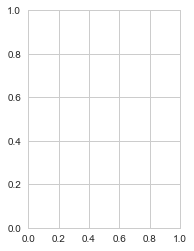

In [35]:
plt.subplot(121)
train_df[train_df['inTag']==0]['interest_level'].hist(normed=1)
pylab.ylim([0,4])
plt.subplot(122)
train_df[train_df['inTag']==1]['interest_level'].hist(normed=1)
pylab.ylim([0,4])